Total mass = 0.002
fixed DOFs = 12
free  DOFs = 48


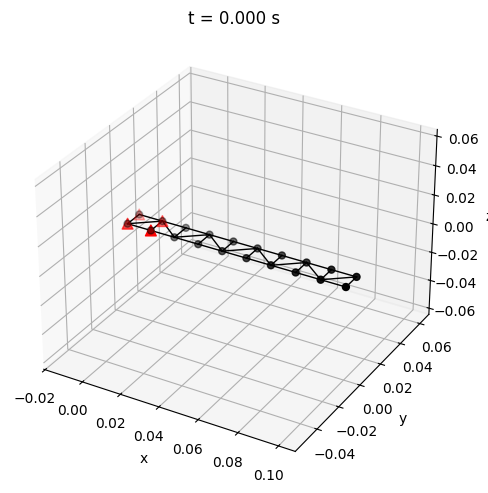

step 0, t = 0.001


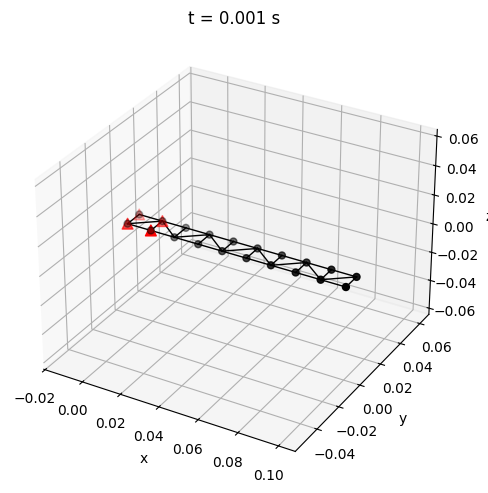

step 1000, t = 1.001


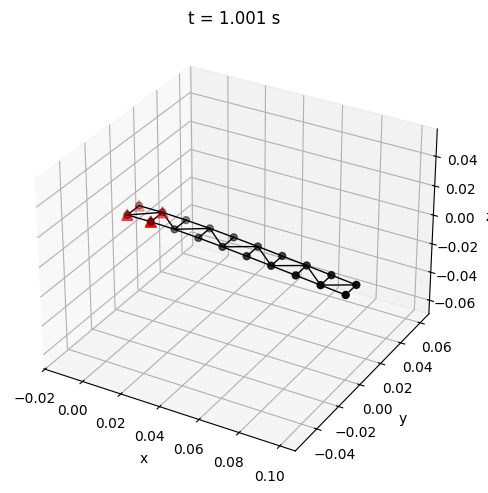

step 2000, t = 2.001


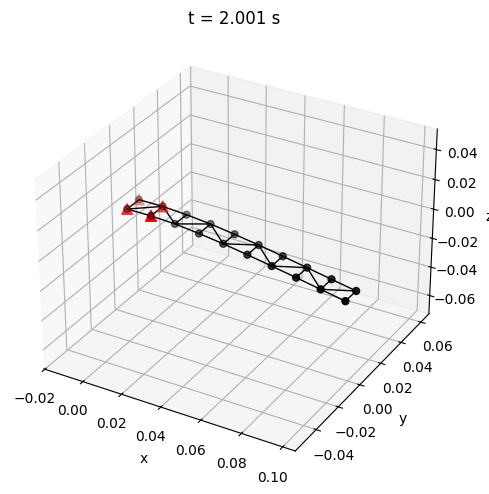

step 3000, t = 3.001


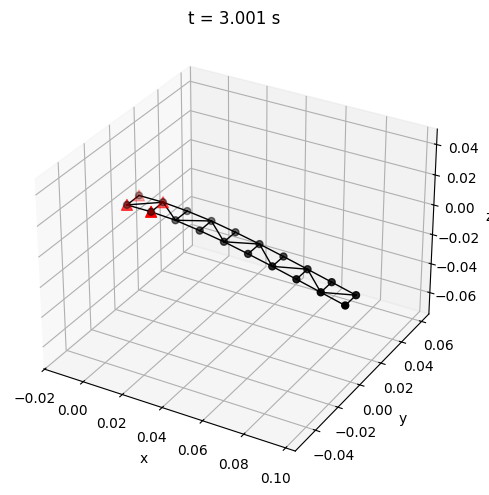

step 4000, t = 4.001


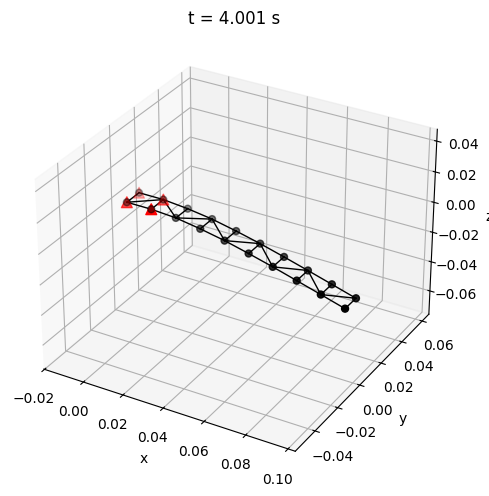

step 5000, t = 5.001


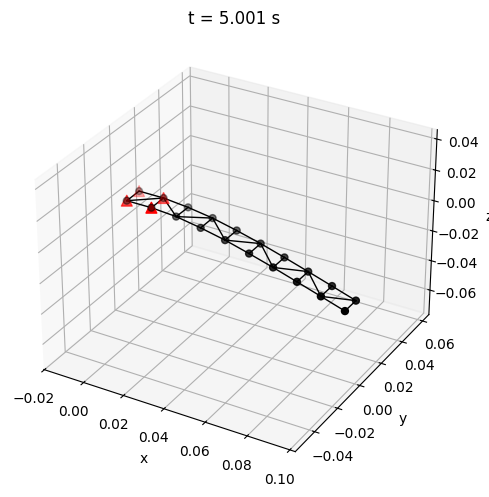

step 6000, t = 6.001


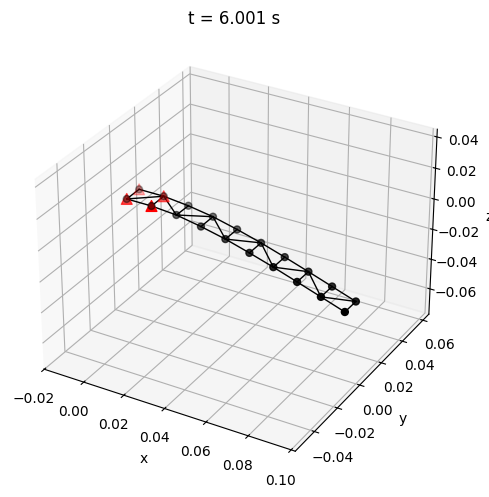

step 7000, t = 7.001


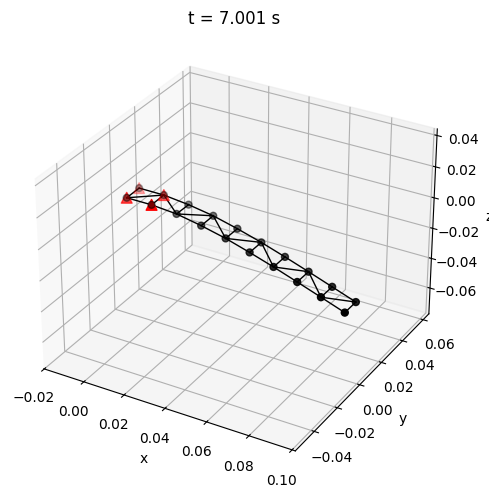

step 8000, t = 8.001


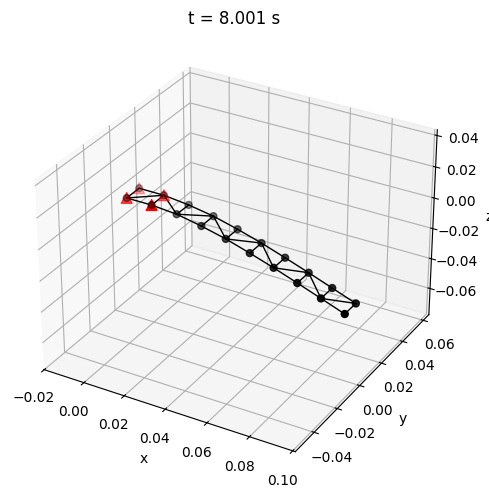

step 9000, t = 9.001


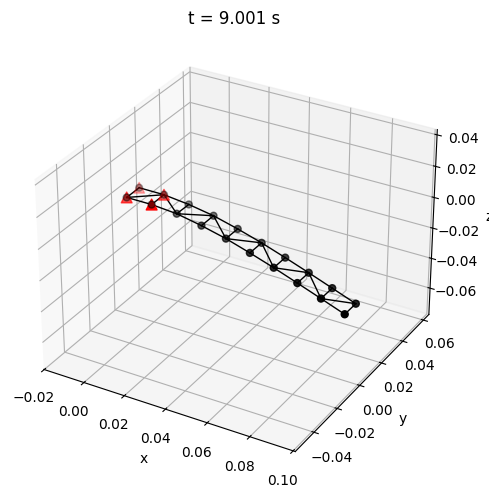

delta_plate_final = 0.03488144749270411
delta_EB          = 0.03675000000000001
relative error    = 0.05084496618492249


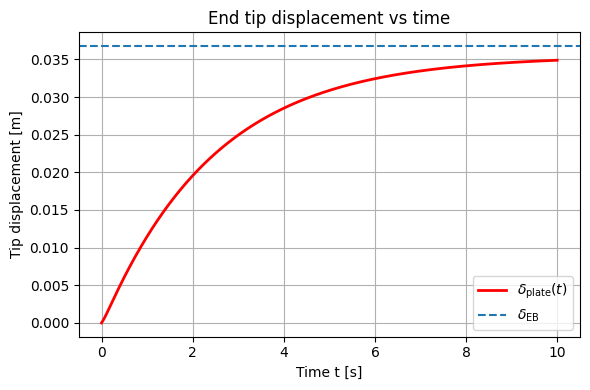

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# -----------------------------------------------------------
# geometry helpers
# -----------------------------------------------------------

def signedAngle(u, v, n):
    """Signed angle between u and v, with sign defined by n."""
    w = np.cross(u, v)
    angle = np.arctan2(np.linalg.norm(w), np.dot(u, v))
    if np.dot(n, w) < 0.0:
        angle = -angle
    return angle


def mmt(M):
    """Make a matrix + its transpose (for symmetric blocks)."""
    return M + M.T


# -----------------------------------------------------------
# dihedral angle and its derivatives (bending)
# -----------------------------------------------------------

def getTheta(x0, x1=None, x2=None, x3=None):
    # also allow 12-vector input
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    e0 = x1 - x0
    e1 = x2 - x0
    e2 = x3 - x0

    n0 = np.cross(e0, e1)
    n1 = np.cross(e2, e0)

    theta = signedAngle(n0, n1, e0)
    return theta


def gradTheta(x0, x1=None, x2=None, x3=None):
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    e0 = x1 - x0
    e1 = x2 - x0
    e2 = x3 - x0
    e3 = x2 - x1
    e4 = x3 - x1

    # cos/sin of the four angles
    cosA1 = np.dot(e0, e1) / (np.linalg.norm(e0) * np.linalg.norm(e1))
    cosA2 = np.dot(e0, e2) / (np.linalg.norm(e0) * np.linalg.norm(e2))
    cosA3 = -np.dot(e0, e3) / (np.linalg.norm(e0) * np.linalg.norm(e3))
    cosA4 = -np.dot(e0, e4) / (np.linalg.norm(e0) * np.linalg.norm(e4))

    sinA1 = np.linalg.norm(np.cross(e0, e1)) / (np.linalg.norm(e0) * np.linalg.norm(e1))
    sinA2 = np.linalg.norm(np.cross(e0, e2)) / (np.linalg.norm(e0) * np.linalg.norm(e2))
    sinA3 = -np.linalg.norm(np.cross(e0, e3)) / (np.linalg.norm(e0) * np.linalg.norm(e3))
    sinA4 = -np.linalg.norm(np.cross(e0, e4)) / (np.linalg.norm(e0) * np.linalg.norm(e4))

    n1 = np.cross(e0, e3); n1 /= np.linalg.norm(n1)
    n2 = -np.cross(e0, e4); n2 /= np.linalg.norm(n2)

    h1 = np.linalg.norm(e0) * sinA1
    h2 = np.linalg.norm(e0) * sinA2
    h3 = -np.linalg.norm(e0) * sinA3   # corrected sign
    h4 = -np.linalg.norm(e0) * sinA4   # corrected sign
    h01 = np.linalg.norm(e1) * sinA1
    h02 = np.linalg.norm(e2) * sinA2

    g = np.zeros(12)
    g[0:3]   =  cosA3 * n1 / h3 + cosA4 * n2 / h4
    g[3:6]   =  cosA1 * n1 / h1 + cosA2 * n2 / h2
    g[6:9]   = -n1 / h01
    g[9:12]  = -n2 / h02

    return g


def hessTheta(x0, x1=None, x2=None, x3=None):
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    e0 = x1 - x0
    e1 = x2 - x0
    e2 = x3 - x0
    e3 = x2 - x1
    e4 = x3 - x1

    cosA1 = np.dot(e0, e1) / (np.linalg.norm(e0) * np.linalg.norm(e1))
    cosA2 = np.dot(e0, e2) / (np.linalg.norm(e0) * np.linalg.norm(e2))
    cosA3 = -np.dot(e0, e3) / (np.linalg.norm(e0) * np.linalg.norm(e3))
    cosA4 = -np.dot(e0, e4) / (np.linalg.norm(e0) * np.linalg.norm(e4))

    sinA1 = np.linalg.norm(np.cross(e0, e1)) / (np.linalg.norm(e0) * np.linalg.norm(e1))
    sinA2 = np.linalg.norm(np.cross(e0, e2)) / (np.linalg.norm(e0) * np.linalg.norm(e2))
    sinA3 = -np.linalg.norm(np.cross(e0, e3)) / (np.linalg.norm(e0) * np.linalg.norm(e3))
    sinA4 = -np.linalg.norm(np.cross(e0, e4)) / (np.linalg.norm(e0) * np.linalg.norm(e4))

    n1 = np.cross(e0, e3); n1 /= np.linalg.norm(n1)
    n2 = -np.cross(e0, e4); n2 /= np.linalg.norm(n2)

    h1  = np.linalg.norm(e0) * sinA1
    h2  = np.linalg.norm(e0) * sinA2
    h3  = -np.linalg.norm(e0) * sinA3
    h4  = -np.linalg.norm(e0) * sinA4
    h01 = np.linalg.norm(e1) * sinA1
    h02 = np.linalg.norm(e2) * sinA2

    m1   = np.cross(n1, e1) / np.linalg.norm(e1)
    m2   = -np.cross(n2, e2) / np.linalg.norm(e2)
    m3   = -np.cross(n1, e3) / np.linalg.norm(e3)
    m4   =  np.cross(n2, e4) / np.linalg.norm(e4)
    m01  = -np.cross(n1, e0) / np.linalg.norm(e0)
    m02  =  np.cross(n2, e0) / np.linalg.norm(e0)

    M331  = cosA3 / (h3**2)      * np.outer(m3,  n1)
    M311  = cosA3 / (h3*h1)      * np.outer(m1,  n1)
    M131  = cosA1 / (h1*h3)      * np.outer(m3,  n1)
    M3011 = cosA3 / (h3*h01)     * np.outer(m01, n1)
    M111  = cosA1 / (h1**2)      * np.outer(m1,  n1)
    M1011 = cosA1 / (h1*h01)     * np.outer(m01, n1)

    M442  = cosA4 / (h4**2)      * np.outer(m4,  n2)
    M422  = cosA4 / (h4*h2)      * np.outer(m2,  n2)
    M242  = cosA2 / (h2*h4)      * np.outer(m4,  n2)
    M4022 = cosA4 / (h4*h02)     * np.outer(m02, n2)
    M222  = cosA2 / (h2**2)      * np.outer(m2,  n2)
    M2022 = cosA2 / (h2*h02)     * np.outer(m02, n2)

    B1 = 1.0 / (np.linalg.norm(e0)**2) * np.outer(n1, m01)
    B2 = 1.0 / (np.linalg.norm(e0)**2) * np.outer(n2, m02)

    N13  = 1.0 / (h01*h3)  * np.outer(n1, m3)
    N24  = 1.0 / (h02*h4)  * np.outer(n2, m4)
    N11  = 1.0 / (h01*h1)  * np.outer(n1, m1)
    N22  = 1.0 / (h02*h2)  * np.outer(n2, m2)
    N101 = 1.0 / (h01**2)  * np.outer(n1, m01)
    N202 = 1.0 / (h02**2)  * np.outer(n2, m02)

    H = np.zeros((12, 12))

    H[0:3, 0:3]   = mmt(M331) - B1 + mmt(M442) - B2
    H[0:3, 3:6]   = M311 + M131.T + B1 + M422 + M242.T + B2
    H[0:3, 6:9]   = M3011 - N13
    H[0:3, 9:12]  = M4022 - N24

    H[3:6, 3:6]   = mmt(M111) - B1 + mmt(M222) - B2
    H[3:6, 6:9]   = M1011 - N11
    H[3:6, 9:12]  = M2022 - N22

    H[6:9, 6:9]   = -mmt(N101)
    H[9:12, 9:12] = -mmt(N202)

    # fill symmetric counterparts
    H[3:6, 0:3]   = H[0:3, 3:6].T
    H[6:9, 0:3]   = H[0:3, 6:9].T
    H[9:12, 0:3]  = H[0:3, 9:12].T
    H[6:9, 3:6]   = H[3:6, 6:9].T
    H[9:12, 3:6]  = H[3:6, 9:12].T

    return H


# -----------------------------------------------------------
# stretching energy for edges
# -----------------------------------------------------------

def gradEs_hessEs(x0, x1, l_ref, EA):
    edge     = x1 - x0
    L        = np.linalg.norm(edge)
    t_hat    = edge / L
    strain   = L / l_ref - 1.0
    dF_unit  = EA * t_hat * strain

    dF = np.zeros(6)
    dF[0:3] = -dF_unit
    dF[3:6] =  dF_unit

    I3 = np.eye(3)
    M  = EA * ((1.0 / l_ref - 1.0 / L) * I3 + (1.0 / L) * np.outer(edge, edge) / (L**2))

    dJ = np.zeros((6, 6))
    dJ[0:3, 0:3] =  M
    dJ[3:6, 3:6] =  M
    dJ[0:3, 3:6] = -M
    dJ[3:6, 0:3] = -M
    return dF, dJ


# -----------------------------------------------------------
# bending energy for shells
# -----------------------------------------------------------

def getEb_shell(x0, x1=None, x2=None, x3=None, theta_ref=0.0, kb=1.0):
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    theta = getTheta(x0, x1, x2, x3)
    E = 0.5 * kb * (theta - theta_ref)**2
    return E


def gradEb_hessEb_shell(x0, x1=None, x2=None, x3=None, theta_ref=0.0, kb=1.0):
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[0:3]

    theta = getTheta(x0, x1, x2, x3)
    gth   = gradTheta(x0, x1, x2, x3)
    Hth   = hessTheta(x0, x1, x2, x3)

    # 写成稍微不一样的形式（但和你朋友的是等价的）
    dtheta = theta - theta_ref
    dF = kb * dtheta * gth
    dJ = kb * (np.outer(gth, gth) + dtheta * Hth)

    return dF, dJ


# -----------------------------------------------------------
# plotting helper
# -----------------------------------------------------------

def set_axes_equal(ax):
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    xr = abs(xlim[1] - xlim[0])
    yr = abs(ylim[1] - ylim[0])
    zr = abs(zlim[1] - zlim[0])
    r  = max(xr, yr, zr)

    xm = np.mean(xlim)
    ym = np.mean(ylim)
    zm = np.mean(zlim)

    ax.set_xlim3d([xm - r/2, xm + r/2])
    ax.set_ylim3d([ym - r/2, ym + r/2])
    ax.set_zlim3d([zm - r/2, zm + r/2])


def plot_shell(q, t, nodes, edges, fixed_nodes=None):
    nv  = nodes.shape[0]
    pts = q.reshape((nv, 3))

    fig = plt.figure(figsize=(7, 5))
    ax  = fig.add_subplot(111, projection='3d')

    # edges
    for i, j in edges:
        p0 = pts[i]
        p1 = pts[j]
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'k-', lw=1.0)

    # all nodes
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c='k', s=25)

    # fixed nodes (red)
    if fixed_nodes is not None and len(fixed_nodes) > 0:
        fn = np.array(fixed_nodes, dtype=int)
        ax.scatter(pts[fn, 0], pts[fn, 1], pts[fn, 2], c='r', s=60, marker='^')

    ax.set_title(f"t = {t:.3f} s")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    set_axes_equal(ax)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# single implicit time step (Newton)
# -----------------------------------------------------------

def implicit_step(q_prev, u_prev, free_idx, dt, tol,
                  mass_vec, mass_mat,
                  ks, ref_len, edges,
                  kb, hinges,
                  Fg, visc):
    """
    One backward-Euler step using Newton iterations.
    Only updates the free DOFs.
    """
    q_new = q_prev.copy()
    ndof  = len(q_prev)

    err = 10.0 * tol
    newton_iter = 0

    while err > tol:
        # ---- bending ----
        Fb = np.zeros(ndof)
        Jb = np.zeros((ndof, ndof))
        for h in range(hinges.shape[0]):
            n0, n1, n2, n3 = hinges[h, :]
            x0 = q_new[3*n0:3*n0+3]
            x1 = q_new[3*n1:3*n1+3]
            x2 = q_new[3*n2:3*n2+3]
            x3 = q_new[3*n3:3*n3+3]

            idx = [3*n0, 3*n0+1, 3*n0+2,
                   3*n1, 3*n1+1, 3*n1+2,
                   3*n2, 3*n2+1, 3*n2+2,
                   3*n3, 3*n3+1, 3*n3+2]

            dF, dJ = gradEb_hessEb_shell(x0, x1, x2, x3, theta_ref=0.0, kb=kb)
            Fb[idx]           -= dF
            Jb[np.ix_(idx, idx)] -= dJ

        # ---- stretching ----
        Fs = np.zeros(ndof)
        Js = np.zeros((ndof, ndof))
        for e in range(edges.shape[0]):
            i0 = edges[e, 0]
            i1 = edges[e, 1]
            x0 = q_new[3*i0:3*i0+3]
            x1 = q_new[3*i1:3*i1+3]

            idx = [3*i0, 3*i0+1, 3*i0+2,
                   3*i1, 3*i1+1, 3*i1+2]

            dF, dJ = gradEs_hessEs(x0, x1, ref_len[e], ks[e])
            Fs[idx] -= dF
            Js[np.ix_(idx, idx)] -= dJ

        # ---- viscous ----
        Fv = -visc * (q_new - q_prev) / dt
        Jv = -visc / dt * np.eye(ndof)

        # total forces and jacobian
        F_total = Fb + Fs + Fg + Fv
        JF      = Jb + Js + Jv

        # EOM residual: M/dt * ((q_new - q_prev)/dt - u_prev) - F_total = 0
        f = mass_vec / dt * ((q_new - q_prev) / dt - u_prev) - F_total
        J = mass_mat / dt**2 - JF

        f_free = f[free_idx]
        J_free = J[np.ix_(free_idx, free_idx)]

        dq_free = np.linalg.solve(J_free, f_free)

        q_new[free_idx] -= dq_free

        err = np.linalg.norm(f_free, ord=np.inf)
        newton_iter += 1

        # 不要在每次迭代里狂刷屏，这里就不 print 了

    u_new = (q_new - q_prev) / dt
    return q_new, u_new


# ===========================================================
# main script
# ===========================================================

# 1) build nodes (2 x 10 grid)
x_cols = np.array([-0.0125, 0.0, 0.0125, 0.025, 0.0375, 0.05,
                   0.0625, 0.075, 0.0875, 0.1])
y_rows = np.array([0.0, 0.01])

nodes = []
for y in y_rows:
    for x in x_cols:
        nodes.append([x, y, 0.0])
nodes = np.array(nodes)       # (20, 3)

nv   = nodes.shape[0]
ndof = 3 * nv
q0   = nodes.reshape(-1)

# 2) faces: alternating diagonals
faces = []
def nid(r, c):
    return r * 10 + c

for c in range(9):
    b0 = nid(0, c)
    b1 = nid(0, c+1)
    t0 = nid(1, c)
    t1 = nid(1, c+1)

    if c % 2 == 0:
        faces.append([b0, b1, t1])
        faces.append([b0, t1, t0])
    else:
        faces.append([t0, t1, b1])
        faces.append([t0, b1, b0])

faces = np.array(faces, dtype=int)

# 3) edges from faces
edge_set = set()
for tri in faces:
    for a, b in [(tri[0], tri[1]),
                 (tri[1], tri[2]),
                 (tri[2], tri[0])]:
        edge_set.add(tuple(sorted((a, b))))
edges = np.array(sorted(edge_set), dtype=int)

# 4) hinges from edges shared by two triangles
edge_to_faces = defaultdict(list)
for f_id, tri in enumerate(faces):
    tri_edges = [
        tuple(sorted((tri[0], tri[1]))),
        tuple(sorted((tri[1], tri[2]))),
        tuple(sorted((tri[2], tri[0])))
    ]
    for e in tri_edges:
        edge_to_faces[e].append(f_id)

hinge_list = []
for e, adj_faces in edge_to_faces.items():
    if len(adj_faces) == 2:
        f0, f1 = adj_faces
        t0 = faces[f0]
        t1 = faces[f1]
        i, j = e
        k0 = [v for v in t0 if v not in e][0]
        k1 = [v for v in t1 if v not in e][0]
        hinge_list.append([i, j, k0, k1])

hinges = np.array(hinge_list, dtype=int)

# 5) material & stiffness
Y   = 1.0e7
h   = 0.002
visc = 0.1

kb = 2.0 / np.sqrt(3.0) * Y * h**3 / 12.0

ref_len = np.zeros(edges.shape[0])
ks      = np.zeros_like(ref_len)
for e in range(edges.shape[0]):
    i0 = edges[e, 0]
    i1 = edges[e, 1]
    x0 = q0[3*i0:3*i0+3]
    x1 = q0[3*i1:3*i1+3]
    ref_len[e] = np.linalg.norm(x1 - x0)
    ks[e]      = np.sqrt(3.0) / 2.0 * Y * h * (ref_len[e]**2)

# 6) time parameters
total_time = 10.0
dt         = 0.001
Nsteps     = int(round(total_time / dt))

tol = kb / 0.01 * 1e-3

# 7) mass, gravity
rho = 1000.0
w   = 0.01
A   = w * h
L   = 0.1

total_mass = rho * A * L
print("Total mass =", total_mass)

m_node = np.ones(nv) * (total_mass / nv)

mass_vec = np.zeros(ndof)
for i in range(nv):
    mass_vec[3*i:3*i+3] = m_node[i]

mass_mat = np.diag(mass_vec)

g_vec = np.array([0.0, 0.0, -9.8])
Fg = np.zeros(ndof)
for i in range(nv):
    idx = [3*i, 3*i+1, 3*i+2]
    Fg[idx] = mass_vec[idx] * g_vec

# 8) fixed DOFs: all nodes with x <= 0
fixed_nodes = []
for i, (x, y, z) in enumerate(nodes):
    if x <= 0.0 + 1e-12:
        fixed_nodes.append(i)

fixed_idx = []
for v in fixed_nodes:
    fixed_idx.extend([3*v, 3*v+1, 3*v+2])
fixed_idx = np.array(fixed_idx, dtype=int)

all_idx  = np.arange(ndof)
free_idx = np.setdiff1d(all_idx, fixed_idx)

print("fixed DOFs =", len(fixed_idx))
print("free  DOFs =", len(free_idx))

# initial state
q_curr = q0.copy()
u_curr = np.zeros(ndof)
t_now  = 0.0

endZ = np.zeros(Nsteps)

# initial plot
plot_shell(q_curr, t_now, nodes, edges, fixed_nodes)

# 9) time stepping
for step in range(Nsteps):
    q_next, u_next = implicit_step(
        q_curr, u_curr, free_idx,
        dt, tol,
        mass_vec, mass_mat,
        ks, ref_len, edges,
        kb, hinges,
        Fg, visc
    )

    t_now += dt
    q_curr = q_next.copy()
    u_curr = u_next.copy()

    # last node's z-coordinate
    endZ[step] = q_curr[-1]

    # 画图/打印频率降低一点
    if step % 1000 == 0:
        print(f"step {step}, t = {t_now:.3f}")
        plot_shell(q_curr, t_now, nodes, edges, fixed_nodes)

# 10) process results: δ_plate(t) and comparison with Euler-Bernoulli
time = np.linspace(0.0, total_time, Nsteps)
delta_plate = - endZ - endZ[0]   # subtract initial tip position (0)

# Euler-Bernoulli cantilever under uniform load
I  = w * h**3 / 12.0
q_load = rho * A * 9.8          # N/m
delta_EB = q_load * L**4 / (8.0 * Y * I)

delta_plate_final = delta_plate[-1]
rel_err = abs(delta_plate_final - delta_EB) / abs(delta_EB)

print("delta_plate_final =", delta_plate_final)
print("delta_EB          =", delta_EB)
print("relative error    =", rel_err)

# plot δ_plate vs time
plt.figure(figsize=(6, 4))
plt.plot(time, delta_plate, 'r-', linewidth=2, label=r'$\delta_{\mathrm{plate}}(t)$')
plt.axhline(y=delta_EB, linestyle='--', label=r'$\delta_{\mathrm{EB}}$')
plt.xlabel("Time t [s]")
plt.ylabel("Tip displacement [m]")
plt.title("End tip displacement vs time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
